In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import os
import sys
import numpy as np
import pandas as pd
import random
import json

!pip install umap-learn
import umap

from scipy.spatial.distance import cdist

from skimage import io
from matplotlib import pyplot as plt
from multiprocessing import Pool, cpu_count

if not os.path.exists('./ngrok'):
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip

plt.rcParams["axes.grid"] = False

!pip install ipython-autotime
%load_ext autotime

# Load the TensorBoard notebook extension
%load_ext tensorboard

print('TENSORFLOW VERSION:',tf.__version__)

--2019-07-26 10:50:15--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.145.109, 52.72.230.122, 52.86.186.182, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.145.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13607069 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  12.98M  32.3MB/s    in 0.4s    

2019-07-26 10:50:15 (32.3 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13607069/13607069]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime
TENSORFLOW VERSION: 1.14.0


In [0]:
# Set up different folders for different runs of the model
!rm -r sample_data
#!rm -r './models'

models_folder = './models'
model_number = 0

if not os.path.exists(models_folder):
    os.makedirs(models_folder)

time: 1.31 s


# TENSORBOARD

In [0]:
# TENSORBOARD LINK
LOG_DIR = models_folder
#LOG_DIR = "resnet50_da_10h"
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://79eeff6f.ngrok.io
time: 1.54 s


In [0]:
#%tensorboard --logdir $LOG_DIR

time: 1.12 ms


# DRIVE FILES

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.14 ms


In [0]:
# TFRecords paths
citius_tfrecords = './drive/My Drive/CiTius/TFRecords/'
citius_jsons = './drive/My Drive/CiTius/JSONs/'

train_file = citius_tfrecords + 'Bark-dataset-Train.tfrecord'
test_file = citius_tfrecords + 'Bark-dataset-Test.tfrecord'
anomalies_test_file = citius_tfrecords + 'Bark-Anomalies-Test.tfrecord'

time: 1.91 ms


# PARAMS

In [118]:
# PARAMS (hyperparameters)

# General params
#######################################################
num_epochs = -1 # 30 by default

embedding_size = 16
filters = [32, 64, 128, 256]

train_data_augmentation = 'hard' # None/'soft'/'hard'

images_for_evaluation = 50
samples_for_evaluation = 16*images_for_evaluation
image_size = 256
input_size = 64


#-----------------------------------------------------#


# WARM START VARIABLES FROM A MODEL WHEN FINE-TUNING
warm_dir = './content/drive/My Drive/CiTius/Trained-Models/...'
make_warm_start = False
train_after_warm_start = False

# LOAD MODEL ONLY WHEN PREDICTING/EVALUATING AND NOT FOR TRAINING
load_model = True
train_loaded = False
reload_model = False
assert not (make_warm_start and load_model),'Cannot load pretrained model and warm start variables at the same time'

if load_model:
    download_path = '/content/drive/My\ Drive/CiTius/Trained-Models/CAE-16-SDA'
    copy_path = '/content/models/'
    model_path = copy_path + download_path.split('/')[-1]
    if reload_model:
        !rm -r $model_path
    if not os.path.exists(model_path):
        !cp -r $download_path $copy_path
#######################################################

prefetch_batches = 20
batch_size = 256
shuffle_size = 10000
eval_batch_size = batch_size
num_channels = 3
learning_rate = 1e-4

# Save checkpoints during training params
save_summary_steps = save_checkpoints_steps = 600
min_secs_eval = 5.0

# Early stopping param
max_steps_without_decrease = 9999999
run_every_steps = save_checkpoints_steps # Run validation every ? steps

# Features when reading Examples
features = {
    'rows': tf.FixedLenFeature([], tf.int64),
    'cols': tf.FixedLenFeature([], tf.int64),
    'channels': tf.FixedLenFeature([], tf.int64),
    'image': tf.FixedLenFeature([], tf.string),
    'label': tf.FixedLenFeature([], tf.int64)
}

time: 6.3 s


# TFRECORD EXTRACTOR

In [119]:
# CLASS TO EXTRACT IMAGES FROM A TFRECORD AND RETURN IN A DATASET
class TFRecordExtractor:
    def __init__(self, tfrecord_file):
        self.tfrecord_file = os.path.abspath(tfrecord_file)

    def _extract_fn(self, tfrecord):
        # Extract the data record
        sample = tf.parse_single_example(tfrecord, features)

        # cast image [0, 255] to [0.0, 1.0]
        image = tf.image.decode_image(sample['image'], dtype=tf.uint8)
        image = tf.cast(image, tf.float32)
        image = image / 255
        img_shape = tf.stack([sample['rows'], sample['cols'], sample['channels']])
        #label = sample['label']
        #label = tf.cast(label, tf.int64)
        #filename = sample['filename']
        
        return image

    def extract_image(self):

        # Pipeline of dataset
        dataset = tf.data.TFRecordDataset([self.tfrecord_file])
        dataset = dataset.map(self._extract_fn)
        
        return dataset

time: 9.55 ms


# DATASET LOADING & INPUT_FN

In [120]:
def all_data_augmentations(image):
    #do_crop = tf.random_uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
    #image = tf.cond(tf.less(do_crop, crop_ratio), lambda: random_crop(image), lambda: image)

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if train_data_augmentation == 'hard':
        image = tf.image.random_brightness(image, max_delta=0.25)
        image = tf.image.random_saturation(image, lower=0.75, upper=1.25)
        image = tf.image.random_contrast(image, lower=0.75, upper=1.25)
        image = tf.image.random_hue(image, max_delta=0.15)
    
    return image

def apply_data_augmentations(dataset):
    
    dataset = dataset.map(all_data_augmentations, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return dataset


time: 7.67 ms


In [121]:
def load_dataset(filePath):
    t = TFRecordExtractor(filePath)
    dataset = t.extract_image()
    return dataset

def load_multiple_datasets(paths):
    final_dataset = None
    for path in paths:
        dataset = load_dataset(path)
        final_dataset = final_dataset.concatenate(dataset) if final_dataset != None else dataset
    return final_dataset

def get_patches(image, patch_stride = input_size):
    ksizes=[1,input_size,input_size,1]
    strides=[1,patch_stride,patch_stride,1]
    rates=[1,1,1,1]
    patches = tf.image.extract_image_patches(tf.reshape(image, (1, image_size, image_size, num_channels)),ksizes,strides,rates,padding='VALID')
    return tf.reshape(patches, (-1, input_size, input_size, num_channels))

time: 7.37 ms


In [122]:
"""Create the input data pipeline using `tf.data`"""
def train_input_fn(train_file):
    if isinstance(train_file, list):
        dataset = load_multiple_datasets(train_file)
    else:
        dataset = load_dataset(train_file)
    
    if train_data_augmentation:
        dataset = apply_data_augmentations(dataset)
    
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.repeat(num_epochs)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(prefetch_batches)  # make sure you always have one batch ready to serve
    return dataset

def single_test_input_fn(test_file):
    dataset = load_dataset(test_file)
    dataset = dataset.take(1)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.batch(eval_batch_size)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def test_input_fn(test_file):
    dataset = load_dataset(test_file)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(prefetch_batches)  # make sure you always have one batch ready to serve
    return dataset

def reduced_test_input_fn(test_file, samples):
    dataset = load_dataset(test_file)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.take(samples)
    dataset = dataset.batch(eval_batch_size)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

def reduced_train_input_fn(train_file, samples):
    dataset = load_dataset(train_file)
    dataset = dataset.map(get_patches, num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.take(samples)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(prefetch_batches)  # make sure you always have one batch ready to serve
    return dataset

def predict_input_fn(test_file, patch_stride=int(input_size/8)):
    dataset = load_dataset(test_file)
    dataset = dataset.map(lambda x: get_patches(x, patch_stride), num_parallel_calls=tf.data.experimental.AUTOTUNE).apply(tf.data.experimental.unbatch())
    dataset = dataset.batch(eval_batch_size)
    dataset = dataset.prefetch(1)  # make sure you always have one batch ready to serve
    return dataset

time: 35.2 ms


# MODEL ARCHITECTURE & MODEL_FN

In [123]:
def autoencoder(inputs, embedding_size=64, kernel_size=3, filters=[32, 64, 128, 256], stride_decode=2):
    reduced_shape = int( filters[-1] * input_size/(2**(len(filters))) * input_size/(2**(len(filters))) )
    
    inputs = tf.reshape(inputs, shape=(-1, input_size, input_size, 3))
    assert inputs.shape[1:] == [input_size, input_size, 3], "{}".format(inputs.shape)

    outputs = {
        'inputs' : inputs,
    }

    # ENCODING
    for filter in filters:
        inputs = tf.layers.conv2d(inputs, filter, kernel_size, padding='same', activation=tf.nn.relu)
        inputs = tf.layers.max_pooling2d(inputs, 2, 2, padding='same')
    inputs = tf.layers.flatten(inputs)
    embeddings = tf.layers.dense(inputs, embedding_size, activation=tf.nn.relu)

    outputs['embeddings'] = embeddings

    # DECODING
    output = tf.layers.dense(embeddings, reduced_shape, activation=tf.nn.relu)
    output = tf.reshape(output, shape=(-1, int(input_size/(2**(len(filters)))), int(input_size/(2**(len(filters)))), filters[-1]))
    for i in range(1, len(filters)):
        output = tf.layers.conv2d_transpose(output, filters[-i], kernel_size, stride_decode, padding='same', activation=tf.nn.relu)
    output = tf.layers.conv2d_transpose(output, num_channels, kernel_size, stride_decode, padding='same', activation=None)

    outputs['reconstructions'] = output

    return outputs

time: 16.7 ms


In [124]:
"""Define the model"""
def model_fn(features, mode):
    """Model function for tf.estimator
    Args:
        features: input batch of images
        mode: can be one of tf.estimator.ModeKeys.{TRAIN, EVAL, PREDICT}
    Returns:
        model_spec: tf.estimator.EstimatorSpec object
    """
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    images = features

    # -----------------------------------------------------------
    with tf.variable_scope('model'):
        results = autoencoder(images, embedding_size=embedding_size, kernel_size=3, filters=filters, stride_decode=2)
        
    images = results['inputs']
    
    embeddings = results['embeddings']
    
    embedding_mean_norm = tf.reduce_mean(tf.norm(embeddings, axis=1))
    tf.summary.scalar("embedding_mean_norm", embedding_mean_norm)

    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            #'inputs' : results['inputs'],
            'embeddings' : results['embeddings'],
            #'outputs': results['reconstructions']
        }
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    
    # -----------------------------------------------------------
    with tf.variable_scope("metrics"):
        eval_metric_ops = {"embedding_mean_norm": tf.metrics.mean(embedding_mean_norm)}
    
    loss = tf.reduce_mean(tf.nn.l2_loss(images - results['reconstructions']))
    
    if mode == tf.estimator.ModeKeys.EVAL:
        # Loss summary for validation set
        #tf.summary.scalar('loss_val', loss)
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)

    
    # Loss summary for train set
    tf.summary.scalar('loss', loss)

    tf.summary.image('train_image', images, max_outputs=1)

    # Define training step that minimizes the loss with the Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    global_step = tf.train.get_global_step()
    train_op = optimizer.minimize(loss, global_step=global_step)

    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

time: 21.5 ms


# TRAIN AND EVALUATE

In [125]:
# MODEL INITIALIZATION AND TRAIN/EVALUATE

tf.reset_default_graph()

tf.logging.set_verbosity(tf.logging.WARN)

if not load_model:
    model_number += 1
    model_dir = models_folder+"/model_"+str(model_number)
else:
    model_dir = model_path

# Define the model
tf.logging.info("Creating the model...")

config = tf.estimator.RunConfig(
                            tf_random_seed=400,
                            model_dir=model_dir,
                            save_summary_steps=save_summary_steps,
                            save_checkpoints_steps=save_checkpoints_steps,
                            train_distribute=None,
                            eval_distribute=None)
config = config.replace(keep_checkpoint_max=1)

if make_warm_start:
    vars_to_initialize = ["^(?!.*(Adam|beta1_power|beta2_power|dense)).*$"] if 'ImageNet' in warm_dir else ["model.*"]
    ws = tf.estimator.WarmStartSettings(ckpt_to_initialize_from=warm_dir, vars_to_warm_start=vars_to_initialize)
    estimator = tf.estimator.Estimator(model_fn, config=config, warm_start_from=ws)
else:
    estimator = tf.estimator.Estimator(model_fn, config=config)

# EVALUATION
tf.logging.info("Evaluation on test set.")
res = estimator.evaluate(lambda: test_input_fn(test_file))
for key in res:
    print("{}: {}".format(key, res[key]))


if (not make_warm_start and not load_model) or (make_warm_start and train_after_warm_start) or (load_model and train_loaded):
    # Train the model
    tf.logging.info("Starting training for {} epoch(s).".format(num_epochs))

    # Set up an early stopping hook for the loss
    if not os.path.exists(estimator.eval_dir()): os.makedirs(estimator.eval_dir())

    early_stopping = tf.estimator.experimental.stop_if_no_decrease_hook(
        estimator,
        metric_name='loss',
        max_steps_without_decrease=max_steps_without_decrease,
        min_steps=10,
        run_every_secs = None,
        run_every_steps = run_every_steps)

    # Train and Evaluate at the same time (producing checkpoints and evaluating for summary)
    train_spec = tf.estimator.TrainSpec(input_fn=lambda: train_input_fn(train_file), hooks=[early_stopping])
    eval_spec = tf.estimator.EvalSpec(input_fn=lambda: test_input_fn(test_file), throttle_secs = min_secs_eval)
    results = tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    print(results)

embedding_mean_norm: 6.992167949676514
loss: 17526.580078125
global_step: 165603
time: 2.69 s


In [0]:
# EVALUATION POST TRAINING

tf.logging.info("Evaluation on test set.")
res = estimator.evaluate(lambda: test_input_fn(test_file))
for key in res:
    print("{}: {}".format(key, res[key]))

embedding_mean_norm: 13.158891677856445
loss: 3470.40234375
global_step: 754200
time: 4.23 s


# PREDICT

In [0]:
# LOAD ALL THE IMAGES OF THE TEST SET
%reset_selective -f "^test_images$"
test_images = []

t = TFRecordExtractor(test_file)
dataset = t.extract_image()

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

count = 0
with tf.Session() as sess:
    while count < images_for_evaluation:
        try:
            sample = sess.run(next_element)
            img = sample
            img = np.reshape(img, newshape= (img.shape[0], img.shape[1], 3) )
            test_images.append( (img, count) )
            count += 1
        except tf.errors.OutOfRangeError:
            break
            
test_images = np.array(test_images)
print('Test images set:',test_images.shape)


# LOAD ALL THE IMAGES OF THE TRAIN SET
%reset_selective -f "^train_images$"

train_images = []

t = TFRecordExtractor(train_file)
dataset = t.extract_image()

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

count = 0
with tf.Session() as sess:
    while count < images_for_evaluation:
        try:
            sample = sess.run(next_element)
            img = sample
            img = np.reshape(img, newshape= (img.shape[0], img.shape[1], 3) )
            train_images.append( (img, count) )
            count += 1
            
        except tf.errors.OutOfRangeError:
            break
            
train_images = np.array(train_images)
print('Train images set:',train_images.shape)

W0718 15:29:13.372755 140581164849024 deprecation.py:323] From <ipython-input-16-a1b1a8df027e>:7: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


Test images set: (50, 2)
Train images set: (50, 2)
time: 1 s


In [0]:
# PREDICT THE TEST SET
%reset_selective -f "^test_results$"
%reset_selective -f "^test_outputs$"
test_results = list(estimator.predict(input_fn=lambda: reduced_test_input_fn(test_file, samples=samples_for_evaluation), yield_single_examples=True))

# GET THE EMBEDDING AND OUTPUT IMAGE FOR ALL THE TEST SET
test_outputs = []

count = 0
for elem in test_results:
    input = elem['inputs']
    emb = elem['embeddings']
    output = elem['outputs']
    output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
    count += 1
    test_outputs.append( (input, emb, output) )
    
test_outputs = np.array(test_outputs)
print('Test results from the CAE:', test_outputs.shape)
test_outputs = np.split(test_outputs, images_for_evaluation)
print('Test results after splitting:', len(test_outputs))
print('Shape of a split:', test_outputs[0].shape)



# PREDICT THE REDUCED TRAIN SET
%reset_selective -f "^train_results$"
%reset_selective -f "^train_outputs$"
train_results = list(estimator.predict(input_fn=lambda: reduced_train_input_fn(train_file, samples=samples_for_evaluation), yield_single_examples=True))

# GET THE EMBEDDING AND OUTPUT IMAGE FOR THE REDUCED TRAIN SET
train_outputs = []

count = 0
for elem in train_results:
    input = elem['inputs']
    emb = elem['embeddings']
    output = elem['outputs']
    output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
    count += 1
    train_outputs.append( (input, emb, output) )
    
train_outputs = np.array(train_outputs)
print('Train results from the CAE:',train_outputs.shape)
train_outputs = np.split(train_outputs, images_for_evaluation)
print('Train results after splitting:', len(train_outputs))
print('Shape of a split:', train_outputs[0].shape)

Test results from the CAE: (800, 3)
Test results after splitting: 50
Shape of a split: (16, 3)
Train results from the CAE: (800, 3)
Train results after splitting: 50
Shape of a split: (16, 3)
time: 2.19 s


# RESULTS VISUALIZATION

In [0]:
# FUNCTION TO VISUALIZE INPUT AND OUTPUT IMAGES OF THE CAE
def visualize_single_results(results, number=0, indexs=[]):
    assert results.shape[0]>0 and results.shape[1]>0
    
    if number > 0:
        for i in range(number):
            result = results[i]
            input = result[0]
            output = result[2]

            f, axarr = plt.subplots(ncols=3, nrows=1, figsize=(10, 7))
            axarr[0].imshow(input)
            axarr[0].set_title('Input-'+str(i))
            axarr[1].imshow(output)
            axarr[1].set_title('Output-'+str(i))
            axarr[2].imshow(abs(input-output))
            axarr[2].set_title('Absolute difference')
            plt.show()
    else:
        assert len(indexs)>0,'Number or indexs must be defined'
        for i in indexs:
            result = results[i]
            input = result[0]
            output = result[2]

            f, axarr = plt.subplots(ncols=3, nrows=1, figsize=(10, 7))
            axarr[0].imshow(input)
            axarr[0].set_title('Input-'+str(i))
            axarr[1].imshow(output)
            axarr[1].set_title('Output-'+str(i))
            axarr[2].imshow(abs(input-output))
            axarr[2].set_title('Absolute difference')
            plt.show()

time: 24.2 ms


W0718 15:29:17.512491 140581164849024 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


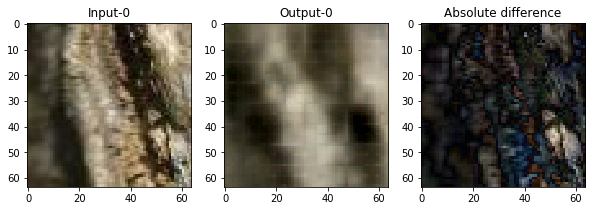

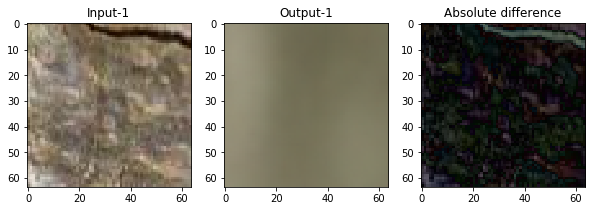

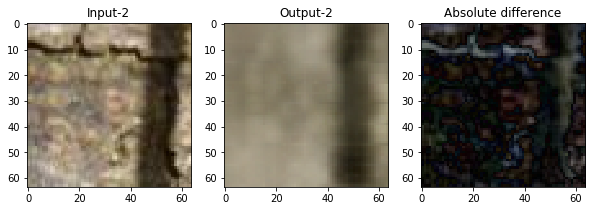

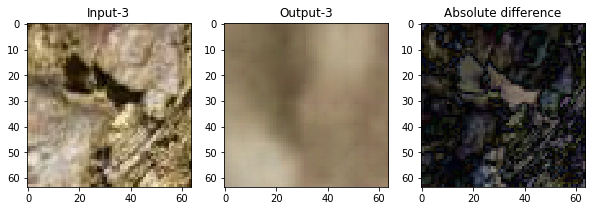

time: 1.69 s


In [0]:
# VISUALIZE SOME TEST RESULTS
visualize_single_results(test_outputs[0], 4)

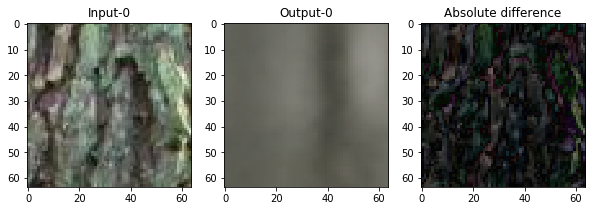

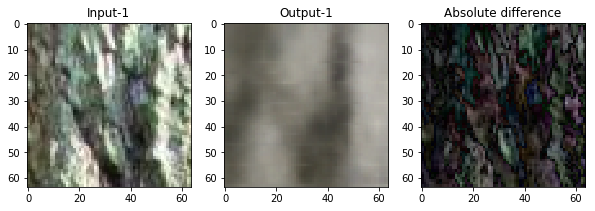

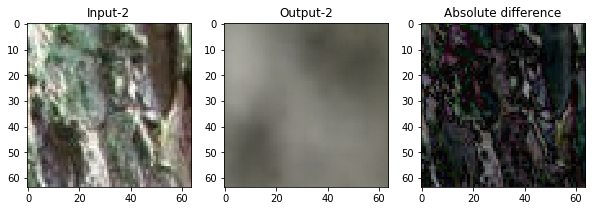

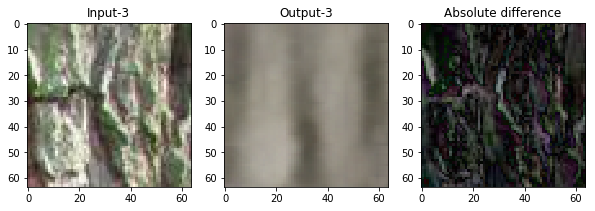

time: 1.69 s


In [0]:
# VISUALIZE SOME TEST RESULTS
visualize_single_results(train_outputs[0], 4)

# EMBEDDINGS VISUALIZATION

In [0]:
# FUNCTION TO VISUALIZE EMBEDDINGS IN A 2D SPACE
def visualize2d_embeddings(embeddings):
    umap2d_embedding = umap.UMAP(random_state=42).fit_transform( list(embeddings) )

    f, axarr = plt.subplots(ncols=1, nrows=1, figsize=(10, 8))
    axarr.set_title('2D UMAP embeddings')
    #axarr.scatter(umap2d_embedding[:, 0], umap2d_embedding[:, 1], c=colors, s=10, cmap='magma')
    axarr.scatter(umap2d_embedding[:, 0], umap2d_embedding[:, 1], c='b', s=10)
    plt.show()

time: 3.66 ms


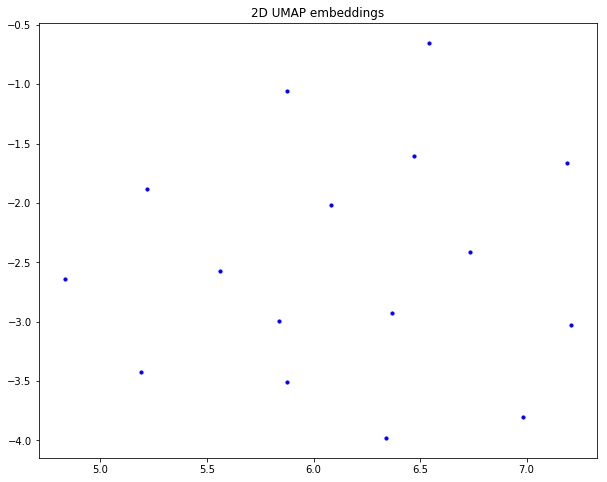

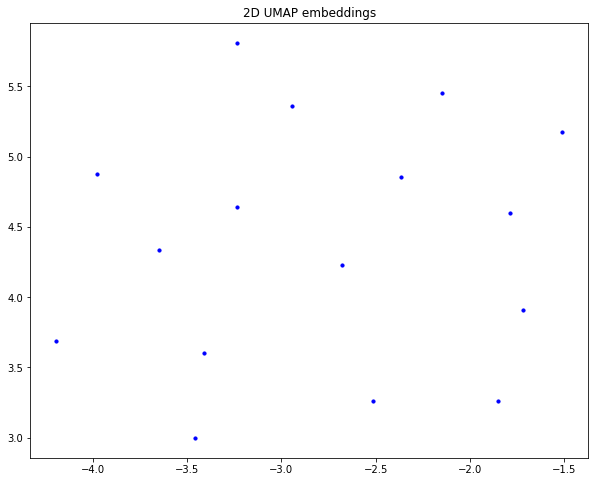

time: 506 ms


In [0]:
# VISUALIZE SOME EMBEDDINGS FROM THE TEST RESULTS
image_embeddings = test_outputs[0][:,1]
visualize2d_embeddings(image_embeddings)

# VISUALIZE SOME EMBEDDINGS FROM THE REDUCED TRAIN RESULTS
image_embeddings = train_outputs[0][:,1]
visualize2d_embeddings(image_embeddings)

# ANOMALY DETECTION COMPUTATIONS

In [0]:
# DEFINE METHOD TO COMPUTE PAIRWISE DISTANCE MATRIX AND RETURN STATS
def borders_outlier_candidates(embeddings, outlier_restriction=3):
    embeddings = np.array( [el for el in embeddings] )
    dist_matrix = cdist(embeddings, embeddings)
    indexs = np.tril_indices(dist_matrix.shape[0], -1)
    triangular = dist_matrix[indexs]
    mean, std = triangular.mean(), triangular.std()
    
    np.fill_diagonal(dist_matrix, mean)
    offset_matrix = abs(dist_matrix-mean) / std
    dist_matrix = offset_matrix > outlier_restriction
    positive_outliers = np.where(dist_matrix)
    outliers_coords = list(zip(positive_outliers[0], positive_outliers[1]))
    
    # COMPUTE THE MOST DIFFERENT EMBEDDING
    #print(np.argmax(offset_matrix))
    #print(np.max(offset_matrix))
    anomaly_candidate = np.unravel_index(offset_matrix.argmax(), offset_matrix.shape)
    
    return anomaly_candidate, outliers_coords

time: 15.2 ms


In [0]:
# COMPUTE PAIRWISE EMBEDDING ANALYSIS FOR SOME TEST EXAMPLES
image_embeddings = test_outputs[0][:,1]
outliers = borders_outlier_candidates(image_embeddings, outlier_restriction=3)
print(outliers)

((13, 15), [])
time: 5.55 ms


In [0]:
# DEFINE METHOD TO COMPUTE THE MOST DIFFERENT EMBEDDING AMONG ALL THE EMBEDDINGS
def embeddings_outlier_candidates(image_index, top=3, norm=2):
    embeddings = test_outputs[image_index][:,1]
    embeddings = np.array( [el for el in embeddings] )
    mean, std = np.mean(embeddings, axis=0), np.std(embeddings, axis=0)
    candidates = np.apply_along_axis(lambda x: np.linalg.norm(x, ord=norm),axis=1,arr=embeddings-mean)
    #candidates = np.less_equal(embeddings, outlier_restriction*std)
    #candidates = (np.sum(candidates, axis=1))
    sorted_candidates, index_candidates = np.sort(candidates)[::-1], np.argsort(candidates)[::-1]
    return index_candidates[:top], sorted_candidates[:top]

time: 6.87 ms


In [0]:
# COMPUTE EMBEDDING ANALYSIS FOR SOME TEST EXAMPLES
image_index = 0
outliers, difference_ratio = embeddings_outlier_candidates(image_index)
print(outliers, difference_ratio)

[3 0 6] [15.47812  15.400262 15.306831]
time: 5.36 ms


# ANOMALY DATASET AND EVALUATION

In [0]:
# LOAD ALL THE IMAGES OF THE ANOMALIES SET
%reset_selective -f "^anomalies_images$"
anomalies_images = []

t = TFRecordExtractor(anomalies_test_file)
dataset = t.extract_image()

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

count = 0
with tf.Session() as sess:
    while True:
        try:
            sample = sess.run(next_element)
            img = sample
            img = np.reshape(img, newshape= (img.shape[0], img.shape[1], 3) )
            anomalies_images.append( (img, count) )
            count += 1
        except tf.errors.OutOfRangeError:
            break

num_anomalies_images = count
            
anomalies_images = np.array(anomalies_images)
print('Anomalies images set:',anomalies_images.shape)

# PREDICT THE ANOMALIES SET
%reset_selective -f "^anomalies_results$"
%reset_selective -f "^anomalies_outputs$"
anomalies_results = list(estimator.predict(input_fn=lambda: predict_input_fn(anomalies_test_file, patch_stride=int(input_size/16)), yield_single_examples=True))

# GET THE EMBEDDING AND OUTPUT IMAGE FOR ALL THE TEST SET
anomalies_outputs = []

count = 0
for elem in anomalies_results:
    input = elem['inputs']
    emb = elem['embeddings']
    output = elem['outputs']
    output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
    count += 1
    anomalies_outputs.append( (input, np.nan, emb, output) )
    
anomalies_outputs = np.array(anomalies_outputs)
anomalies_outputs = anomalies_outputs[:,[0,2,3]]
print('Test results from the Anomalies dataset:', anomalies_outputs.shape)
anomalies_outputs = np.split(anomalies_outputs, num_anomalies_images)
print('Test results after splitting:', len(anomalies_outputs))
print('Shape of a split:', anomalies_outputs[0].shape)

Anomalies images set: (10, 2)
Test results from the Anomalies dataset: (24010, 3)
Test results after splitting: 10
Shape of a split: (2401, 3)
time: 6.42 s


In [0]:
def visualize_candidates(index_image, indexs):
    to_show = []
    for i in indexs:
        input = anomalies_outputs[index_image][i,0]
        to_show.append( (input, i) )
        if len(to_show)%4 == 0:
            f, axarr = plt.subplots(ncols=4, nrows=1, figsize=(10, 7))
            axarr[0].imshow(to_show[0][0])
            axarr[0].set_title(to_show[0][1])
            axarr[1].imshow(to_show[1][0])
            axarr[1].set_title(to_show[1][1])
            axarr[2].imshow(to_show[2][0])
            axarr[2].set_title(to_show[2][1])
            axarr[3].imshow(to_show[3][0])
            axarr[3].set_title(to_show[3][1])
            plt.show()
            to_show = []

# DEFINE METHOD FOR COMPUTING AND VISUALIZING EMBEDDING-BASED OUTLIERS
def compute_and_visualize_embeddings(index_image, top=16, it=1, norm=1):
    image_embeddings = anomalies_outputs[index_image][:,1]
    outliers, difference_ratio = embeddings_outlier_candidates(image_embeddings, top, norm)
    new_embedding_space = image_embeddings[outliers]
    for i in range(1, it):
        print(new_embedding_space.shape)
        top = int(top/2)
        outliers, difference_ratio = embeddings_outlier_candidates(new_embedding_space, top, norm)
        new_embedding_space = new_embedding_space[outliers]
    print('Indexs of the candidates:',outliers)
    print('Ratios of the candidates:',difference_ratio)
    visualize_candidates(index_image, outliers)

time: 20.3 ms


Indexs of the candidates: [ 440  391  489  185  136  146   87  342   97  195 1415  244  293 1909
 1464  234]
Ratios of the candidates: [12.924793 12.851704 12.752153 12.738265 12.723537 12.67539  12.623903
 12.609781 12.559787 12.542064 12.508392 12.480143 12.468167 12.440174
 12.436805 12.435529]


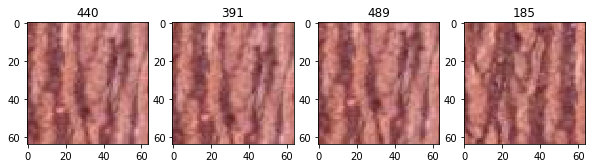

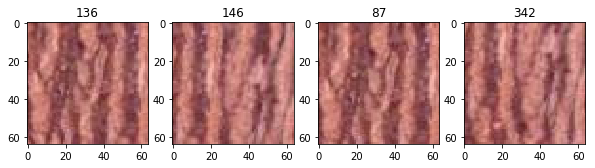

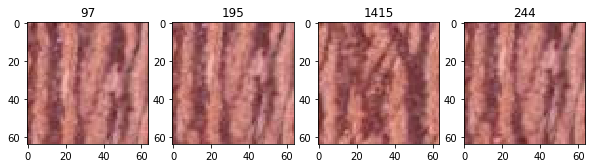

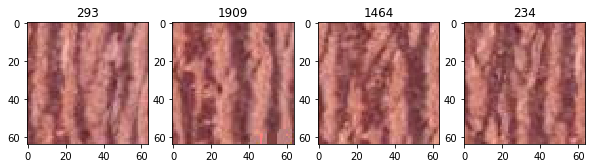

time: 1.87 s


In [0]:
compute_and_visualize_embeddings(9, top=16, it=1, norm=1)

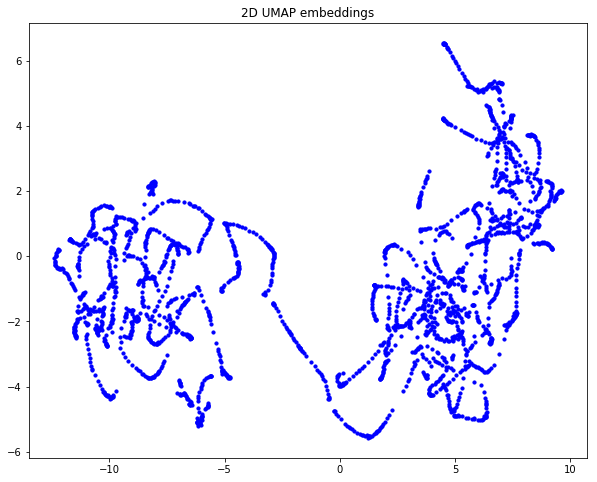

time: 5.98 s


In [0]:
# VISUALIZE SOME EMBEDDINGS FROM THE TEST RESULTS
image_embeddings = anomalies_outputs[9][:,1]
visualize2d_embeddings(image_embeddings)

# ANOMALY ACCURACY

In [126]:
#-------------------------PARAMS--------------------------#
sliding_window_stride = 8
dataset_name = 'Bark-External-Quantitative'
only_differences = True

num_anomalies_images = 500
#---------------------------------------------------------#

def json_to_dict(path):
    with open(path) as json_file:  
        data = json.load(json_file)
    return data

anomalies_quantitative_file = citius_tfrecords + dataset_name + '.tfrecord'
json_file = citius_jsons + dataset_name + '.json'


# PREDICT THE TEST SET
%reset_selective -f "^test_results$"
%reset_selective -f "^anomalies_outputs$"

centers = json_to_dict(json_file)
test_results = estimator.predict(input_fn=lambda: predict_input_fn(anomalies_quantitative_file, sliding_window_stride), yield_single_examples=True)


# GET THE EMBEDDING AND OUTPUT IMAGE FOR ALL THE TEST SET
anomalies_outputs = []

count = 0
def generate_embeddings():
    global count
    for elem in test_results:
        #input = elem['inputs']
        emb = elem['embeddings']
        #output = elem['outputs']
        #output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
        count += 1
        #anomalies_outputs.append( (input, emb, output) )
        yield emb
    
num_windows = int( (image_size-input_size)/sliding_window_stride )+1
anomalies_outputs = np.array( list(generate_embeddings()) )
print('Test results from the CAE:', anomalies_outputs.shape)
anomalies_outputs = np.split(anomalies_outputs, num_anomalies_images)
print('Test results after splitting:', len(anomalies_outputs))
print('Shape of a split:', anomalies_outputs[0].shape)
print('Sliding window stride:',sliding_window_stride)
assert int(anomalies_outputs[0].shape[0]**(1/2)) == num_windows,'Error in num of windows per axis'

Test results from the CAE: (312500, 16)
Test results after splitting: 500
Shape of a split: (625, 16)
Sliding window stride: 8
time: 18 s


In [127]:
##############################DEFINITIONS######################################

def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    Parameters:
      filename : File path or existing ExcelWriter
                 (Example: '/path/to/file.xlsx')
      df : dataframe to save to workbook
      sheet_name : Name of sheet which will contain DataFrame.
                   (default: 'Sheet1')
      startrow : upper left cell row to dump data frame.
                 Per default (startrow=None) calculate the last row
                 in the existing DF and write to the next row...
      truncate_sheet : truncate (remove and recreate) [sheet_name]
                       before writing DataFrame to Excel file
      to_excel_kwargs : arguments which will be passed to `DataFrame.to_excel()`
                        [can be dictionary]

    Returns: None
    """
    from openpyxl import load_workbook

    import pandas as pd

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)

        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)

        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()
    
    
def visualize_candidates(index_image, indexs):
    to_show = []
    image_split = anomalies_outputs[index_image]
    for i in indexs:
        input = image_split[i,0]
        to_show.append( (input, i) )
        if len(to_show)%4 == 0:
            f, axarr = plt.subplots(ncols=4, nrows=1, figsize=(10, 7))
            axarr[0].imshow(to_show[0][0])
            axarr[0].set_title(to_show[0][1])
            axarr[1].imshow(to_show[1][0])
            axarr[1].set_title(to_show[1][1])
            axarr[2].imshow(to_show[2][0])
            axarr[2].set_title(to_show[2][1])
            axarr[3].imshow(to_show[3][0])
            axarr[3].set_title(to_show[3][1])
            plt.show()
            to_show = []


# DEFINE METHOD TO COMPUTE THE MOST DIFFERENT EMBEDDING AMONG ALL THE EMBEDDINGS
def embeddings_outlier_candidates(image_index, top=-1, outlier_threshold=-999999, norm=2):
    embeddings = anomalies_outputs[image_index]
    #print(embeddings.shape)
    #embeddings = np.array( [el for el in embeddings] )
    mean = np.mean(embeddings, axis=0)
    distances = np.apply_along_axis(lambda x: np.linalg.norm(x, ord=norm),axis=1,arr=embeddings-mean)
    
    candidate_distances, candidate_indexs = np.sort(distances)[::-1], np.argsort(distances)[::-1]
    mean_distance, std_distance = np.mean(candidate_distances), np.std(candidate_distances)
    
    threshold_index = np.where(candidate_distances >= mean_distance+outlier_threshold*std_distance)[0]
    
    if len(threshold_index) <= 0:
        return [], []
    
    threshold_index = threshold_index[-1]+1
    
    candidate_indexs, candidate_distances = candidate_indexs[:threshold_index], candidate_distances[:threshold_index]
    if top >= 0: return candidate_indexs[:top], candidate_distances[:top]
    return candidate_indexs, candidate_distances

def check_detections(image_index, detected_indexs, center_tolerance=0):
    assert center_tolerance >= 0,'Center tolerance must be >= 0'
    if len(detected_indexs) <= 0: return 0
    
    center = centers[str(image_index)]
    
    anomaly_detected = False
    i = 0
    if center_tolerance == 0:
        while not anomaly_detected and i < len(detected_indexs):
            index_candidate = detected_indexs[i]
            start_row, start_col = int(index_candidate/num_windows)*sliding_window_stride, (index_candidate % num_windows)*sliding_window_stride
            end_row, end_col = start_row+input_size, start_col+input_size
            anomaly_detected = (start_row <= center[0] <= end_row) and (start_col <= center[1] <= end_col)
            #print(center)
            #print('Rows:',start_row, end_row)
            #print('Cols:',start_col, end_col)
            
            i += 1
    else:
        raise NotImplementedError
    
    return int(anomaly_detected)

def evaluate_anomaly_image(image_index, top_anomalies=-1, outlier_threshold=-999999, center_tolerance=0, verbose=False):
    anomaly_indexs, candidate_distances = embeddings_outlier_candidates(image_index, top=top_anomalies, outlier_threshold=outlier_threshold)
    detected = check_detections(image_index, anomaly_indexs, center_tolerance)
    
    if verbose:
        print('Indexs of the anomalies:',anomaly_indexs)
        print('Absolute differences of the anomalies:',candidate_distances)
        print('Detected anomaly?',detected==1)
        
    return detected

def evaluate_all_anomalies_images(top_anomalies=-1, outlier_threshold=-9999, center_tolerance=0, verbose=False):
    sum = 0
    for image_index in range(len(anomalies_outputs)):
        detected = evaluate_anomaly_image(image_index, top_anomalies, outlier_threshold, center_tolerance)
        sum += detected
        if verbose:
            print('Image num',image_index,'detected anomaly?',detected==1)
    
    return sum*100/len(anomalies_outputs)

def compute_accuracy(threshold):
    if threshold < 0: threshold_label = 'All'
    else: threshold_label = (str(threshold))[:3]
    model_name = 'CAE-'+ str(embedding_size) + '-' + threshold_label + '-' + str(sliding_window_stride)
    
    accuracies = {}
    for n in range(1, max_top):
        accuracy = evaluate_all_anomalies_images(top_anomalies=n, outlier_threshold=threshold, verbose=False)
        accuracies[columns[n-1]] = accuracy

        #print('Top',n,'accuracy:',accuracy)
        if accuracy >= 100: break

    return model_name, pd.Series(accuracies)

time: 178 ms


In [128]:
max_top = min(50, num_windows**2) + 1
columns = ['Top '+str(n) for n in range(1, 51)]
df = pd.DataFrame(columns=columns)
print(compute_accuracy(-np.inf))

('CAE-16-All-8', Top 1     21.8
Top 2     22.8
Top 3     24.4
Top 4     25.8
Top 5     27.0
Top 6     28.4
Top 7     29.6
Top 8     30.8
Top 9     31.8
Top 10    33.4
Top 11    35.0
Top 12    36.2
Top 13    36.8
Top 14    37.8
Top 15    38.4
Top 16    39.0
Top 17    40.8
Top 18    41.0
Top 19    41.0
Top 20    41.8
Top 21    42.2
Top 22    43.0
Top 23    44.4
Top 24    45.4
Top 25    46.0
Top 26    46.2
Top 27    47.0
Top 28    47.6
Top 29    47.8
Top 30    48.2
Top 31    48.2
Top 32    49.8
Top 33    50.0
Top 34    50.6
Top 35    50.6
Top 36    51.0
Top 37    51.6
Top 38    52.2
Top 39    52.4
Top 40    53.2
Top 41    53.6
Top 42    53.6
Top 43    53.6
Top 44    54.0
Top 45    54.0
Top 46    54.6
Top 47    55.0
Top 48    56.2
Top 49    56.4
Top 50    56.6
dtype: float64)
time: 1min 55s


In [0]:
max_top = min(50, num_windows**2) + 1
columns = ['Top '+str(n) for n in range(1, 51)]
df = pd.DataFrame(columns=columns)

thresholds = np.insert(np.arange(0.0, 3.1, 0.1), 0, -np.inf)
print('Available cores:',cpu_count())
pool = Pool(4)

thresholds = pool.map(compute_accuracy, thresholds)

#accuracy_computer = functools.partial(compute_accuracy, anomalies_results=anomalies_results, max_top=max_top, centers=centers, columns=columns)
#thresholds = pool.map(accuracy_computer, thresholds)

pool.close()
pool.join()

for model_name, series in thresholds:
    df.loc[model_name] = series

print(df)

# SAVE DATAFRAME TO DRIVE EXCEL
#excel_path = './drive/My Drive/CiTius/INPAINTING-RESULTS/'+dataset_type+'_Inpainting_Accuracy_results.xlsx'
#print(excel_path)
#append_df_to_excel(excel_path, df)

# CLEAR ACCURACY

In [0]:
#-------------------------PARAMS--------------------------#
sliding_window_stride = 8
dataset_name = 'Bark-Clear-Quantitative'
only_differences = True

num_anomalies_images = 500
#---------------------------------------------------------#

def json_to_dict(path):
    with open(path) as json_file:  
        data = json.load(json_file)
    return data

anomalies_quantitative_file = citius_tfrecords + dataset_name + '.tfrecord'
json_file = citius_jsons + dataset_name + '.json'


# PREDICT THE TEST SET
%reset_selective -f "^test_results$"
%reset_selective -f "^anomalies_outputs$"

centers = json_to_dict(json_file)
test_results = estimator.predict(input_fn=lambda: predict_input_fn(anomalies_quantitative_file, sliding_window_stride), yield_single_examples=True)


# GET THE EMBEDDING AND OUTPUT IMAGE FOR ALL THE TEST SET
anomalies_outputs = []

count = 0
def generate_embeddings():
    global count
    for elem in test_results:
        #input = elem['inputs']
        emb = elem['embeddings']
        #output = elem['outputs']
        #output = np.reshape(output, newshape= (output.shape[0], output.shape[1], 3) )
        count += 1
        #anomalies_outputs.append( (input, emb, output) )
        yield emb
    
num_windows = int( (image_size-input_size)/sliding_window_stride )+1
anomalies_outputs = np.array( list(generate_embeddings()) )
print('Test results from the CAE:', anomalies_outputs.shape)
anomalies_outputs = np.split(anomalies_outputs, num_anomalies_images)
print('Test results after splitting:', len(anomalies_outputs))
print('Shape of a split:', anomalies_outputs[0].shape)
print('Sliding window stride:',sliding_window_stride)
assert int(anomalies_outputs[0].shape[0]**(1/2)) == num_windows,'Error in num of windows per axis'

Test results from the CAE: (312500, 2048)
Test results after splitting: 500
Shape of a split: (625, 2048)
Sliding window stride: 8
time: 21 s


In [0]:
##############################DEFINITIONS######################################

def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    Parameters:
      filename : File path or existing ExcelWriter
                 (Example: '/path/to/file.xlsx')
      df : dataframe to save to workbook
      sheet_name : Name of sheet which will contain DataFrame.
                   (default: 'Sheet1')
      startrow : upper left cell row to dump data frame.
                 Per default (startrow=None) calculate the last row
                 in the existing DF and write to the next row...
      truncate_sheet : truncate (remove and recreate) [sheet_name]
                       before writing DataFrame to Excel file
      to_excel_kwargs : arguments which will be passed to `DataFrame.to_excel()`
                        [can be dictionary]

    Returns: None
    """
    from openpyxl import load_workbook

    import pandas as pd

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)

        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)

        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()
    
    
def visualize_candidates(index_image, indexs):
    to_show = []
    image_split = anomalies_outputs[index_image]
    for i in indexs:
        input = image_split[i,0]
        to_show.append( (input, i) )
        if len(to_show)%4 == 0:
            f, axarr = plt.subplots(ncols=4, nrows=1, figsize=(10, 7))
            axarr[0].imshow(to_show[0][0])
            axarr[0].set_title(to_show[0][1])
            axarr[1].imshow(to_show[1][0])
            axarr[1].set_title(to_show[1][1])
            axarr[2].imshow(to_show[2][0])
            axarr[2].set_title(to_show[2][1])
            axarr[3].imshow(to_show[3][0])
            axarr[3].set_title(to_show[3][1])
            plt.show()
            to_show = []


# DEFINE METHOD TO COMPUTE THE MOST DIFFERENT EMBEDDING AMONG ALL THE EMBEDDINGS
def embeddings_outlier_candidates(image_index, top=-1, outlier_threshold=-999999, norm=2):
    embeddings = anomalies_outputs[image_index]
    #print(embeddings.shape)
    #embeddings = np.array( [el for el in embeddings] )
    mean = np.mean(embeddings, axis=0)
    distances = np.apply_along_axis(lambda x: np.linalg.norm(x, ord=norm),axis=1,arr=embeddings-mean)
    
    candidate_distances, candidate_indexs = np.sort(distances)[::-1], np.argsort(distances)[::-1]
    mean_distance, std_distance = np.mean(candidate_distances), np.std(candidate_distances)
    
    threshold_index = np.where(candidate_distances >= mean_distance+outlier_threshold*std_distance)[0]
    
    if len(threshold_index) <= 0:
        return [], []
    
    threshold_index = threshold_index[-1]+1
    
    candidate_indexs, candidate_distances = candidate_indexs[:threshold_index], candidate_distances[:threshold_index]
    if top >= 0: return candidate_indexs[:top], candidate_distances[:top]
    return candidate_indexs, candidate_distances

def check_detections(image_index, detected_indexs, center_tolerance=0):
    assert center_tolerance >= 0,'Center tolerance must be >= 0'
    if len(detected_indexs) <= 0: return 0
    
    center = centers[str(image_index)]
    
    anomaly_detected = False
    i = 0
    if center_tolerance == 0:
        while not anomaly_detected and i < len(detected_indexs):
            index_candidate = detected_indexs[i]
            start_row, start_col = int(index_candidate/num_windows)*sliding_window_stride, (index_candidate % num_windows)*sliding_window_stride
            end_row, end_col = start_row+input_size, start_col+input_size
            anomaly_detected = (start_row <= center[0] <= end_row) and (start_col <= center[1] <= end_col)
            #print(center)
            #print('Rows:',start_row, end_row)
            #print('Cols:',start_col, end_col)
            
            i += 1
    else:
        raise NotImplementedError
    
    return int(anomaly_detected)

def evaluate_anomaly_image(image_index, top_anomalies=-1, outlier_threshold=-999999, center_tolerance=0, verbose=False):
    anomaly_indexs, candidate_distances = embeddings_outlier_candidates(image_index, top=top_anomalies, outlier_threshold=outlier_threshold)
    detected = len(anomaly_indexs) != 0
    
    if verbose:
        print('Indexs of the anomalies:',anomaly_indexs)
        print('Absolute differences of the anomalies:',candidate_distances)
        print('Detected anomaly?',detected==1)
        
    return detected

def evaluate_all_anomalies_images(top_anomalies=-1, outlier_threshold=-9999, center_tolerance=0, verbose=False):
    sum = 0
    for image_index in range(len(anomalies_outputs)):
        detected = evaluate_anomaly_image(image_index, top_anomalies, outlier_threshold, center_tolerance)
        sum += detected
        if verbose:
            print('Image num',image_index,'detected anomaly?',detected==1)
    
    return sum*100/len(anomalies_outputs)

def compute_accuracy(threshold):
    if threshold < 0: threshold_label = 'All'
    else: threshold_label = (str(threshold))[:3]
    model_name = 'CAE-'+ str(embedding_size) + '-' + threshold_label + '-' + str(sliding_window_stride)
    
    accuracies = {}
    for n in range(1, max_top):
        accuracy = evaluate_all_anomalies_images(top_anomalies=n, outlier_threshold=threshold, verbose=False)
        accuracies[columns[n-1]] = accuracy

        #print('Top',n,'accuracy:',accuracy)
        if accuracy >= 100: break

    return model_name, pd.Series(accuracies)

time: 170 ms


In [0]:
max_top = min(50, num_windows**2) + 1
columns = ['Top '+str(n) for n in range(1, 51)]
df = pd.DataFrame(columns=columns)
print(compute_accuracy(-np.inf))

('CAE-2048-All-8', Top 1    100.0
dtype: float64)
time: 3.63 s


In [0]:
max_top = min(50, num_windows**2) + 1
columns = ['Top '+str(n) for n in range(1, 51)]
df = pd.DataFrame(columns=columns)

thresholds = np.insert(np.arange(0.0, 3.1, 0.1), 0, -np.inf)
print('Available cores:',cpu_count())
pool = Pool(4)

thresholds = pool.map(compute_accuracy, thresholds)

#accuracy_computer = functools.partial(compute_accuracy, anomalies_results=anomalies_results, max_top=max_top, centers=centers, columns=columns)
#thresholds = pool.map(accuracy_computer, thresholds)

pool.close()
pool.join()

for model_name, series in thresholds:
    df.loc[model_name] = series

print(df)

# SAVE DATAFRAME TO DRIVE EXCEL
#excel_path = './drive/My Drive/CiTius/INPAINTING-RESULTS/'+dataset_type+'_Inpainting_Accuracy_results.xlsx'
#print(excel_path)
#append_df_to_excel(excel_path, df)

Available cores: 4


Process ForkPoolWorker-2:
Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  F

KeyboardInterrupt: ignored

time: 3min 42s


# ESTIMATOR TO DRIVE

In [0]:
def estimator_to_drive(clean_save=True):
    drive_path = '/content/drive/My\ Drive/CiTius/Trained-Models/'
    copy_path = drive_path + model_dir.split('/')[-1]
    if clean_save:
        !rm -r $copy_path
    if not os.path.exists(copy_path):
        !cp -r $model_dir $drive_path
        

estimator_to_drive()

rm: cannot remove '/content/drive/My Drive/CiTius/Trained-Models/model_1': No such file or directory
time: 6.92 s
